In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import mne, re, os
import torch
import pickle

from utils import *

In [9]:
SNR = 100.0
#PARCELLATION = 'aparc.a2009s'
PARCELLATION = 'HCPMMP1_combined'
DATA_PATH = '/home/williamtheodor/Documents/DL for EEG Classification/data/'

data_dict = load_mmidb_data_dict(DATA_PATH, PARCELLATION, SNR, chop=True)

In [10]:
DATA_PATH_RAW = '../../data/eegmmidb (raw)/files/'
DATA_PATH_CONCEPTS = '../../data/sanity check concepts MMIDB open_closed/'

bands = data_dict.keys()
patients_to_exclude = ['S088', 'S089', 'S090', 'S092', 'S104', 'S106']
patients = [key for key in data_dict['Alpha'].keys() if key not in patients_to_exclude]
baseline_runs = ['R01', 'R02']

subjects_dir, subject, trans, src_path, bem_path = get_fsaverage()
labels = get_labels(subjects_dir, parcellation_name=PARCELLATION)
label_names = [label.name for label in np.array(labels).flatten()]

#bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
#bands = ['Alpha']
bands = ['Alpha', 'Gamma']

In [11]:
for label_idx in range(len(label_names)):
    for band in bands:
    # make directory if it doesn't exist
        if not os.path.exists(f'{DATA_PATH_CONCEPTS}{band}_{label_names[label_idx]}'):
            os.makedirs(f'{DATA_PATH_CONCEPTS}{band}_{label_names[label_idx]}')

In [12]:
NUMNER_PATIENTS = len(patients)
NUMBER_RUNS = len(baseline_runs)
NUMBER_WINDOWS = 15
NUMBER_CHANNELS = 20

NUMBER_BANDS = len(bands)
NUMBER_LABELS = len(label_names)

WINDOW_LENGTH = 4 # seconds
SAMPLING_FREQ = 256 # Hz
NUMBER_SAMPLES = int(WINDOW_LENGTH*SAMPLING_FREQ)


for patient in tqdm(patients):    
    for run in baseline_runs:

        FILE = DATA_PATH_RAW+f'{patient}/{patient}{run}.edf'

        raw = get_raw(FILE)

        raw_chops = get_raw_chops(raw)

        #baseline_activity_mean = data_dict['Alpha'][patient][patient+run]['T0'].mean(axis=0).reshape(NUMBER_LABELS)
        baseline_activty_means = np.array([data_dict[band][patient][patient+run]['T0'].mean(axis=0)for band in bands]).reshape(NUMBER_BANDS, NUMBER_LABELS) 
        #baseline_activity_std = data_dict['Alpha'][patient][patient+run]['T0'].std(axis=0).reshape(NUMBER_LABELS)
        baseline_activty_stds = np.array([data_dict[band][patient][patient+run]['T0'].std(axis=0)for band in bands]).reshape(NUMBER_BANDS, NUMBER_LABELS)

        for chop_idx, raw_chop in enumerate(raw_chops):
            raw_chop = pick_and_rename_MMIDB_channels(raw_chop) 

            #activity = data_dict['Alpha'][patient][patient+run]['T0'][chop_idx]
            activities = np.array([data_dict[band][patient][patient+run]['T0'][chop_idx] for band in bands])

            #activity = np.abs(activity - baseline_activity_mean) / baseline_activity_std
            activities = np.abs(activities - baseline_activty_means) #/ baseline_activty_stds

            most_active_band_idx = np.argmax(activities.mean(axis=1))
            most_active_band = bands[most_active_band_idx]
            #print(most_active_band)

            brain_region_idx = activities[most_active_band_idx].argmax()
            brain_region = label_names[brain_region_idx]

            concept = most_active_band + '_' + brain_region

            x = np.zeros((1, NUMBER_CHANNELS, NUMBER_SAMPLES))
            x[:,:19,:] = raw_chop.copy().get_data()[:,:NUMBER_SAMPLES].reshape(1,NUMBER_CHANNELS-1,NUMBER_SAMPLES)
            x[:,19,:] = np.ones((1, NUMBER_SAMPLES)) * -1  
            x = torch.from_numpy(x).float()
            
            picklePath = DATA_PATH_CONCEPTS + concept + '/' + patient + run + '_' + str(chop_idx) + '_' + concept + '.pkl'
            with open(picklePath, 'wb') as handle:
                pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 103/103 [00:55<00:00,  1.86it/s]


In [6]:
# for each folder in DATA_PATH_CONCEPTS illustarte the number of files in the folder

#CONCEPT_FOLDER = '../../data/sanity check concepts MMIDB/'
CONCEPT_FOLDER = '../../data/sanity check concepts MMIDB open_closed/'

R01 = []
R02 = []

for folder in sorted(os.listdir(CONCEPT_FOLDER)):
    R01.append(len([file for file in os.listdir(CONCEPT_FOLDER+folder) if 'R01' in file]))
    R02.append(len([file for file in os.listdir(CONCEPT_FOLDER+folder) if 'R02' in file]))

# the same for T1 and T2

T1 = []
T2 = []

labelsxx = []

for folder in sorted(os.listdir(CONCEPT_FOLDER)):

    temp_1 = len([file for file in os.listdir(CONCEPT_FOLDER+folder) if 'T1' in file])
    temp_2 = len([file for file in os.listdir(CONCEPT_FOLDER+folder) if 'T2' in file])

    if temp_1 > 20 and temp_2 > 20:
        T1.append(temp_1)
        T2.append(temp_2)
        labelsxx.append(folder)

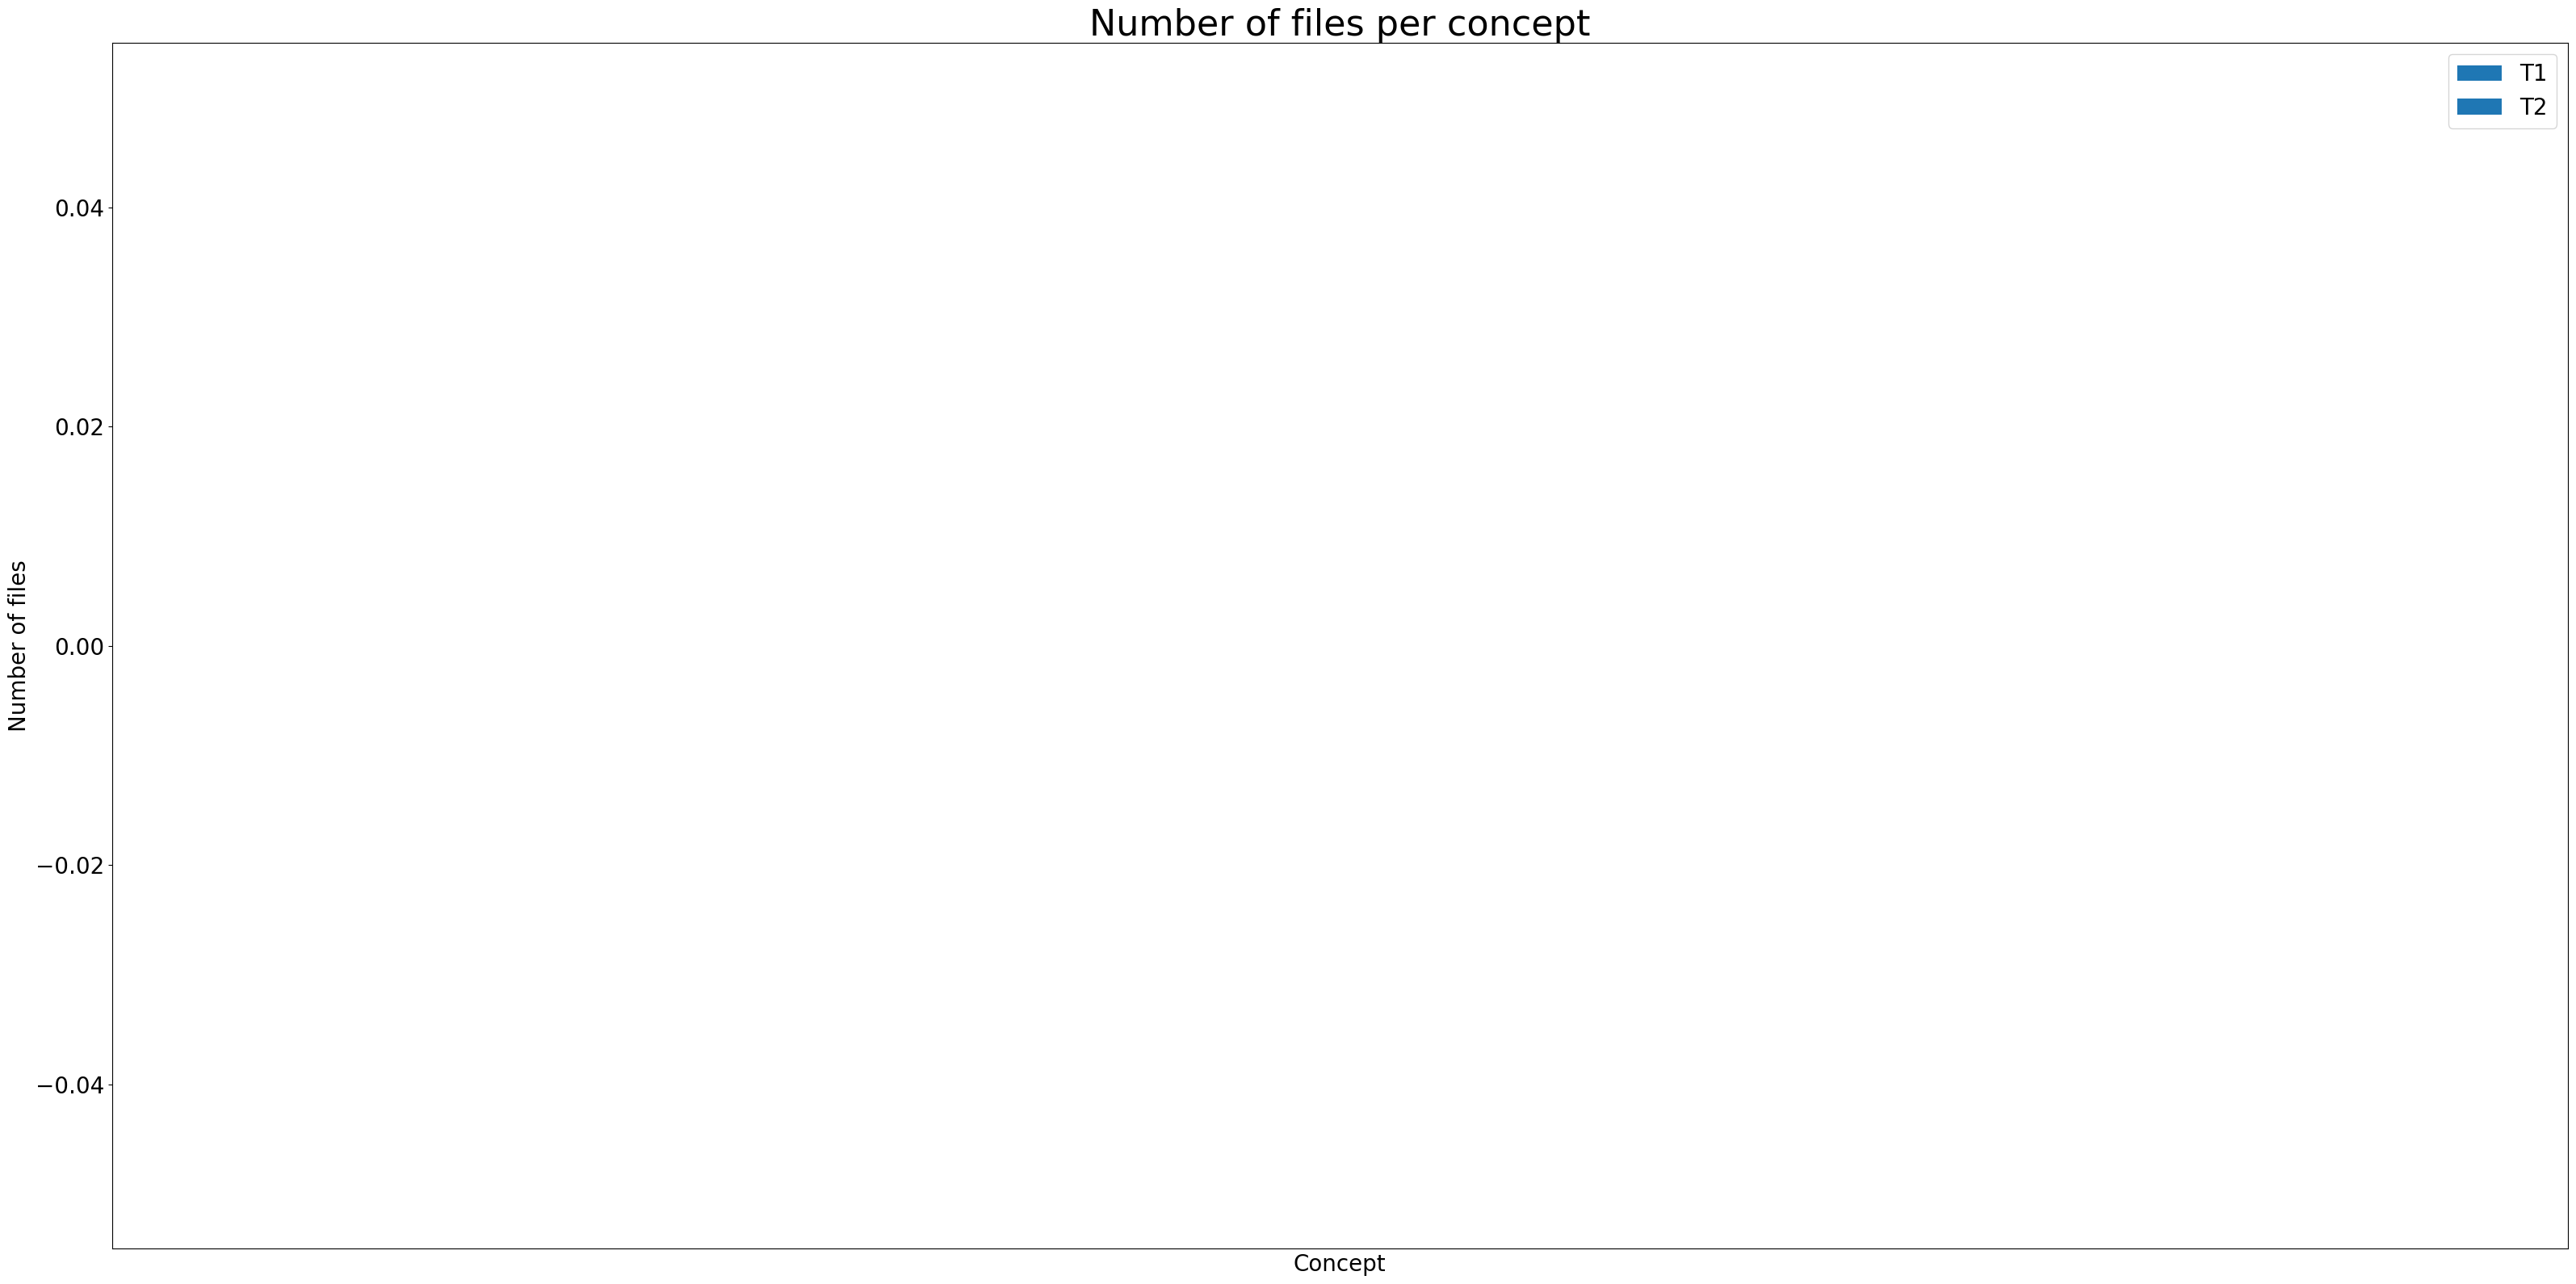

In [7]:
# create paried bar plot of R1 and R2
x = np.arange(len(T1))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(32,16))
#rects1 = ax.bar(x - width/2, R01, width, label='R01')
#rects2 = ax.bar(x + width/2, R02, width, label='R02')
# use T1 and T2 instead
rects1 = ax.bar(x - width/2, T1, width, label='T1')
rects2 = ax.bar(x + width/2, T2, width, label='T2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of files')
ax.set_title('Number of files per concept')
#ax.set_xticks(x)
#ax.set_xticklabels(sorted(os.listdir(DATA_PATH_CONCEPTS)), rotation=90)
ax.legend()

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

ax.set_xticks(x)
ax.set_xticklabels(labelsxx, rotation=90, fontsize=20)

ax.set_xlabel('Concept', fontsize=20)
ax.set_ylabel('Number of files', fontsize=20)

ax.set_title('Number of files per concept', fontsize=32)

ax.margins(x=0)

ax.legend(fontsize=20)

fig.tight_layout()

plt.show()